<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Модель--решающего-дерева" data-toc-modified-id="Модель--решающего-дерева-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель  решающего дерева</a></span></li><li><span><a href="#Модель--случайного-леса" data-toc-modified-id="Модель--случайного-леса-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель  случайного леса</a></span></li><li><span><a href="#Модель--CatBoost" data-toc-modified-id="Модель--CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель  CatBoost</a></span></li><li><span><a href="#Модель--LightGBM" data-toc-modified-id="Модель--LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель  LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Разработка системы предсказания объема заказа.

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключение бибилиотек

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
warnings.filterwarnings('ignore')

Открытие файла, сразу установим дату в индекс, отсортируем датасет ипо инлдексу и посмотрим на него:

In [ ]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


В датасете 26496 строк, данные с 1 марта 2018 по 31 августа 2018 за каждые 10 минут

Проверим на наличие пропущенных значений

In [ ]:
print('Пропущенных значений:',df.isnull().sum())

Пропущенных значений: num_orders    0
dtype: int64


Проверка,что индекс монотонный

In [ ]:
print(df.index.is_monotonic)

True


Проведем ресэмплированные данных по 1 часу, просуммировав количество заказов за каждый час:

In [ ]:
df = df .resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Вывод**

В датасете 26496 строк, данные по числу заказов такси за полгода: с 1 марта 2018 по 31 августа 2018, за каждые 10 минут. Мы проверили данные на дубликаты и провели ресэмплирование данных на каждый час.

## Анализ

Посмотрим на данные за все время:

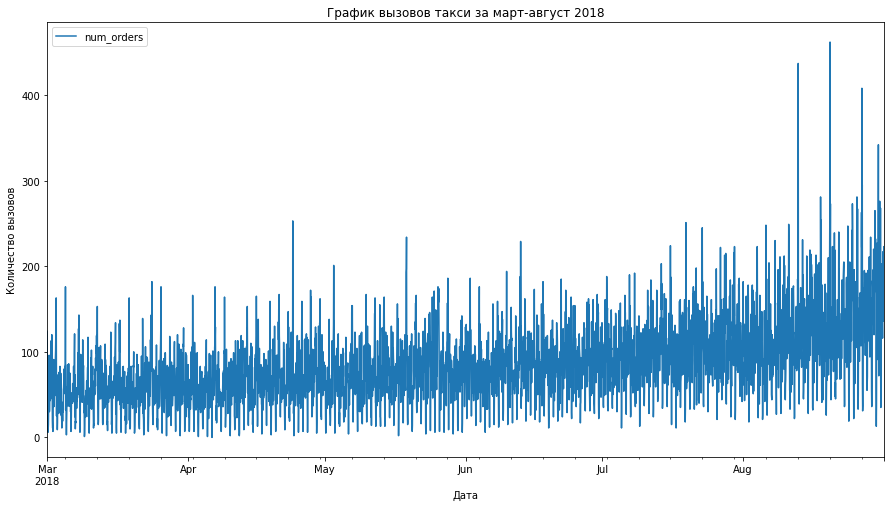

In [ ]:
df.plot(figsize=(15,8))
plt.title("График вызовов такси за март-август 2018")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

Есть намек на восходящий тренд, но при таком объеме данных сложно анализировтаь их покграфику, разобем временной ряд на составляющие:

In [ ]:
decomposed = seasonal_decompose(df)

Выведем полученные составляющие на графике: тренд, сезонность, шум. На графике тренда добавим график скользящей средней по неделям:

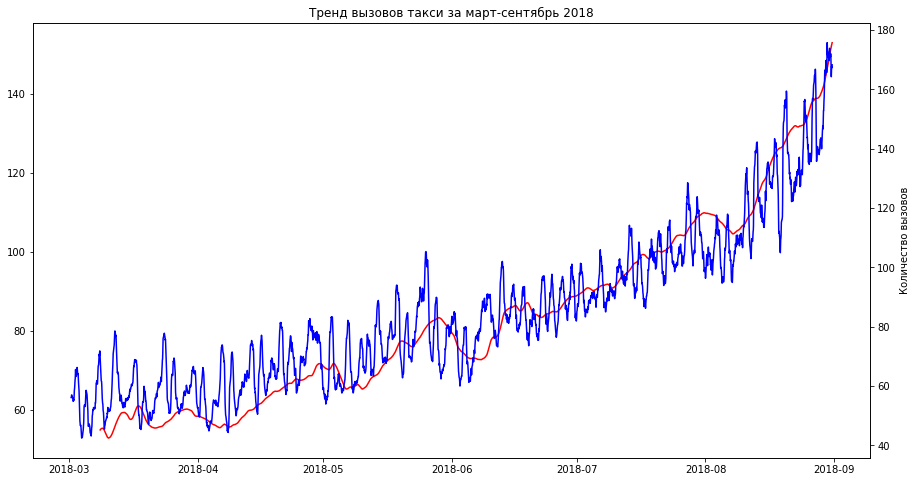

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax1 = ax.twinx()
ax.plot(decomposed.trend.rolling(168).mean(),color='r')
ax1.plot(decomposed.trend,color='b')
plt.title("Тренд вызовов такси за март-сентябрь 2018")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

Наблюдаем восходящий тренд с марта по август с небольшими провалами

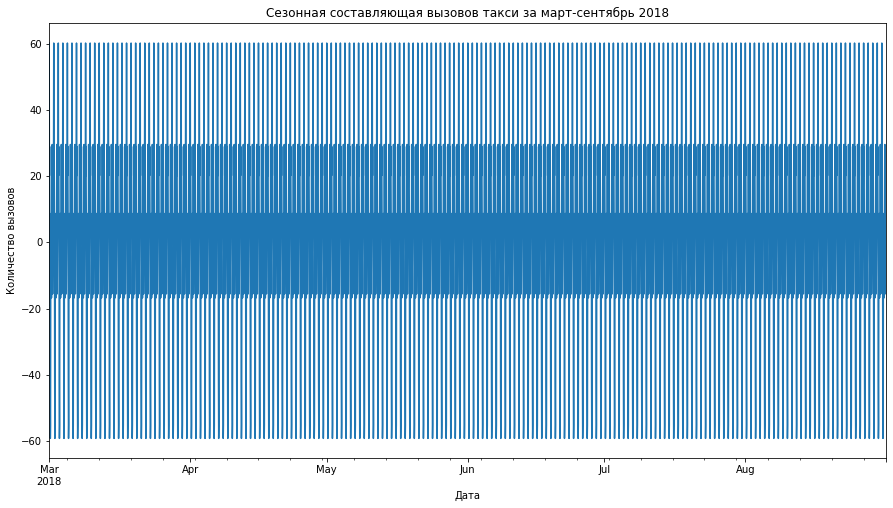

In [ ]:
#decomposed.seasonal.plot(figsize=(15,8))
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,8))
plt.title("Сезонная составляющая вызовов такси за март-сентябрь 2018")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

В таком масштабе ничего не видно, проанализируем сезонную составляющую за сутки, т.к. при почасовом ресемплинге именно такую сезоноость отловит декомпозиция:

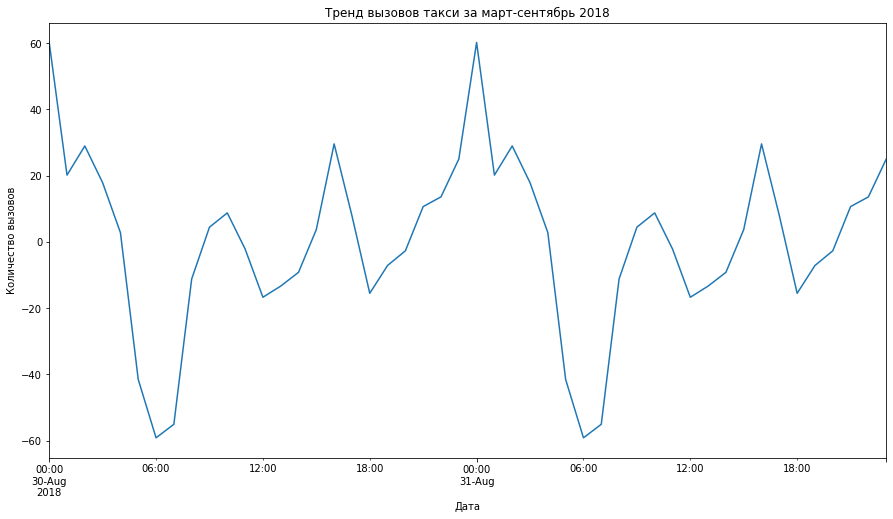

In [ ]:
#decomposed.seasonal.plot(figsize=(15,8))
decomposed.seasonal['2018-08-30': '2018-08-31'].plot(ax=plt.gca(), figsize=(15,8))
plt.title("Тренд вызовов такси за март-сентябрь 2018")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

Тут уже наблюдаем явные провалы количества вызовов к 6 утра и подъем количества вызовов с 18 до 24ч.

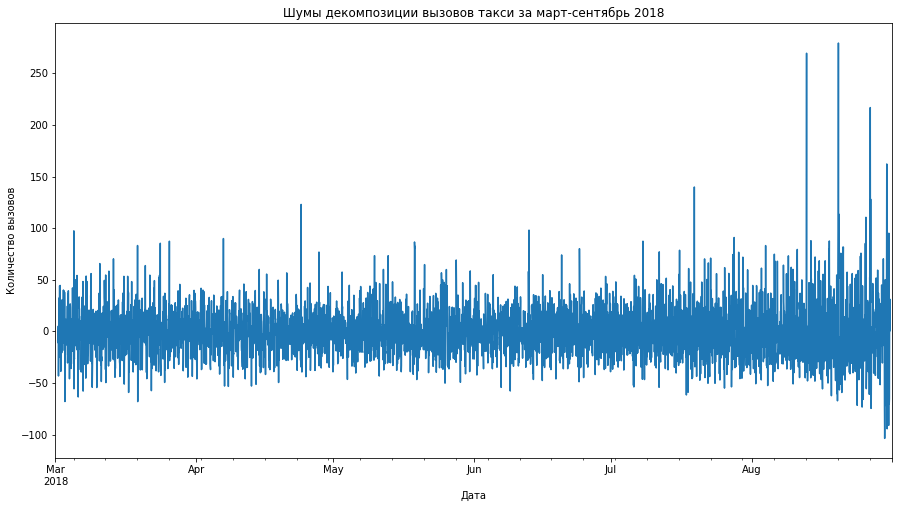

In [ ]:
decomposed.resid.plot(figsize=(15,8))
plt.title("Шумы декомпозиции вызовов такси за март-сентябрь 2018")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

А теперь попробуем выделить тренд и сезонность на ресемплированному по суткам датасете, тогда декомпозиция должна уловить другой масштаб трендов и сезонности.

Ресэмплирование по 24ч

In [ ]:
df_days = df .resample('24H').sum()
df_days.head(10)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441
2018-03-08,1659
2018-03-09,1076


Декомпозируем новый датасет и выводим на гарфики тренд,сезонность

In [ ]:
decomposed_days = seasonal_decompose(df_days)

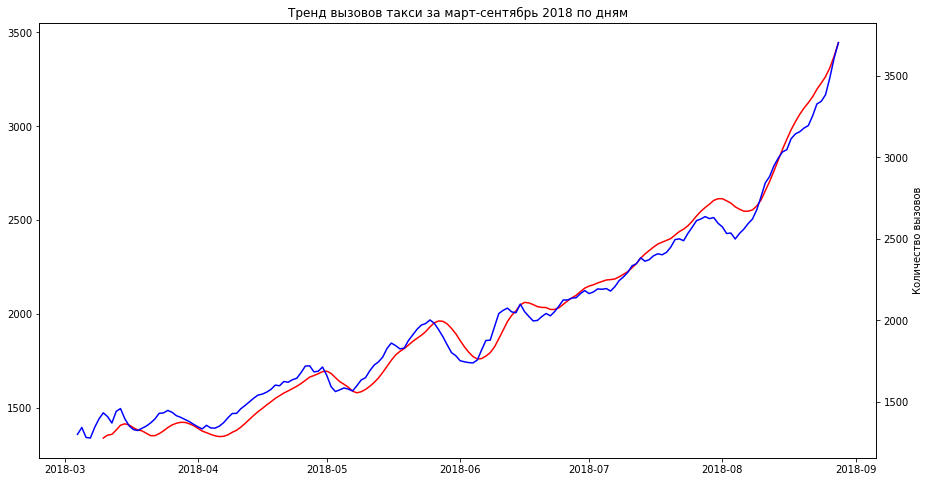

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax1 = ax.twinx()
ax.plot(decomposed_days.trend.rolling(7).mean(),color='r')
ax1.plot(decomposed_days.trend,color='b')
plt.title("Тренд вызовов такси за март-сентябрь 2018 по дням")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

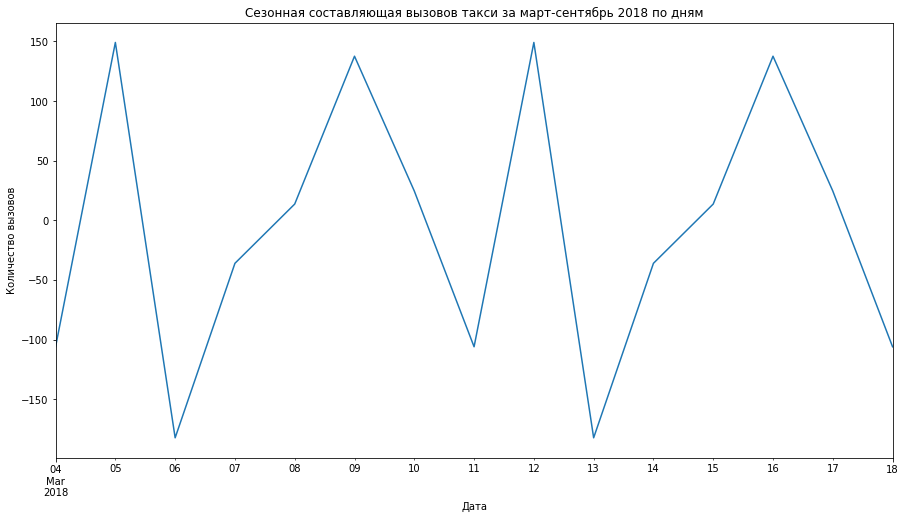

In [ ]:
decomposed_days.seasonal['2018-03-04': '2018-03-18'].plot(ax=plt.gca(), figsize=(15,8))
plt.title("Сезонная составляющая вызовов такси за март-сентябрь 2018 по дням")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");

При таком разбиении стала видна недельная сезонная составляющая. Пики по понедельникам и пятницам и спады во вторники и воскресенья.

Общая тенденция к росту числа заказов, больше заказывают в вечернее время, к 6 утра число заказов падает.

Когда мы создаем прогнозирующую Модель (Model) для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой Ковариацией Выборок одного размера.

Обратимся к тесту ADF (расширенный тест Дики – Фуллера) – проверке Статистической значимости, которая демонстрирует результаты проверки Нулевой гипотезы и Альтернативной. В результате мы получим P-значение, из которого можно сделать вывод о Стационарности Временного ряда.

In [ ]:
result = adfuller(df['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Вывод**

Мы проанализировали временной ряд, увидели общую тенденцию к росту числа заказов такси, проанализировали сезоные составляющие  - обнаружили суточную сезонность, недельную сезонность, убедились по тесту Дики-Фуллера в стационарности временного ряда,а знаичт можно переходить к обучению моделей и прогнозированию.

## Обучение

Создадим функцию, которая добавляет в датасет новые признаки (час, день недели,месяц, отстающие знаечния, скользящее среднее)  с гиперпараметрами -максимальное отставание и размер окна:

In [ ]:
def make_features(data, max_lag, rolling_mean_size):

    data_copy = data.copy()
    data_copy['hour'] = data.index.hour
    data_copy['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)
    return data_copy

Гиперпараметры будем подбирать эксперементально, для начала попробуем максимальное отставание в 5 и окно в 24ч

In [ ]:
data = make_features(df, 24, 24)
data.shape

(4392, 28)

In [ ]:
data.head(10)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333
2018-03-02 05:00:00,11,5,4,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,56.000000
2018-03-02 06:00:00,11,6,4,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,56.208333
2018-03-02 07:00:00,7,7,4,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,56.166667
2018-03-02 08:00:00,46,8,4,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,55.833333


Выделим обучающие и целевой признаки, разобьем датасет на обучающую, тетсовую и валидационную выборки, перемешивать дынне при этом нельзя:

In [ ]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 27)
(440, 27)
(3952,)
(440,)


Обучим различные модели и проанализируем получаемый RMSE. Проанализируем слудующие модели:
- линейная регрессия
- дерево решений
- случайный лес
- CatBoost
- LightGBM

In [ ]:
result_table =[]

### Линейная регрессия ###

Создадим функцию для кросс-валидации без перемшивания:

In [ ]:
def performTimeSeriesCV(X_train, y_train, number_folds, model):
    print('Размер тренировочной выборки: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Размер каждого фолда: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Разбиение первых ' + str(i) + ' кусков на ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = mean_squared_error(model.predict(X_testFold), y_testFold)**0.5

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

Создадим модель линейной регрессии и оценим знаечние RMSE

In [ ]:
%%time
model_linear = LinearRegression()
rmse_linear= performTimeSeriesCV(features_train, target_train, 5, model_linear)
print('\nRMSE линейной регрессии:', rmse_linear)

Размер тренировочной выборки: (3952, 27)
Размер каждого фолда: 790

Разбиение первых 2 кусков на 1/2
Size of train + test: (1580, 27)

Разбиение первых 3 кусков на 2/3
Size of train + test: (2370, 27)

Разбиение первых 4 кусков на 3/4
Size of train + test: (3160, 27)

Разбиение первых 5 кусков на 4/5
Size of train + test: (3950, 27)

RMSE линейной регрессии: 27.257773255338932
CPU times: user 168 ms, sys: 332 ms, total: 500 ms
Wall time: 491 ms


In [ ]:
result_table.append (['Линейная регрессия',rmse_linear])

### Модель  решающего дерева ###

Подберем наилучшие параметры:

In [ ]:
model = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth':range(1,11,2)}
tscv = TimeSeriesSplit(n_splits=2)
model_tree = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
model_tree.fit(features_train, target_train)
tree_rmse = model_tree.best_score_
print(f'Лучший RMSE :{-1*model_tree.best_score_}, лучшая модель: {model_tree.best_estimator_}')

Лучший RMSE :32.43626491361871, лучшая модель: DecisionTreeRegressor(max_depth=5, random_state=12345)


In [ ]:
result_table.append ([f'Дерево решений ({model_tree.best_params_})',-1*tree_rmse])

### Модель  случайного леса ###

Подберем наилучшие параметры

In [ ]:
model = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,15,2)}
tscv = TimeSeriesSplit(n_splits=2)
model_forest = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
model_forest.fit(features_train, target_train)
forest_rmse = model_forest.best_score_
print(f'Лучший RMSE :{-1*model_forest.best_score_}, лучшая модель: {model_forest.best_estimator_}')

Лучший RMSE :27.80018087362216, лучшая модель: RandomForestRegressor(max_depth=11, n_estimators=80, random_state=12345)


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>комментарий студента</b></font>
   Исправлено!
</div>


Вычислим знаечние RMSЕ на подобранных параметрах и добавим в таблицу

In [ ]:
result_table.append ([f'Случайный лес({model_forest.best_params_})',-1*forest_rmse])

### Модель  CatBoost ###

Подберем наиилучшие параметры

In [ ]:
%%time
model = CatBoostRegressor(loss_function='RMSE', learning_rate=0.4,random_state=12345,  verbose=False)
parameters = {'n_estimators':range(50,100,10), 'depth':range(1,15,2)}
tscv = TimeSeriesSplit(n_splits=2)
model_cat = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
model_cat.fit(features_train, target_train)
cat_rmse= model_cat.best_score_
print(f'Лучший RMSE :{-1*model_cat.best_score_}, лучшая модель: {model_cat.best_params_}')

Лучший RMSE :27.15349364550913, лучшая модель: {'depth': 3, 'n_estimators': 70}
CPU times: user 6min 40s, sys: 2.61 s, total: 6min 42s
Wall time: 10min 11s


Добавим результаты в таблицу

In [ ]:
result_table.append ([f'CatBoost({model_cat.best_params_})',-1*cat_rmse])

### Модель  LightGBM ###

Подберем наиилучшие параметры

In [ ]:
#%%time
#model = lgb.LGBMRegressor(learning_rate=0.1 ,random_state=12345)
#parameters = {'n_estimators':range(50,100,10), 'max_depth':range(2,15,2), 'num_leaves':range(4,11,2)}
#tscv = TimeSeriesSplit(n_splits=2)
#model_lgbm = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
#model_lgbm.fit(features_train, target_train)
#best_rmse = model_lgbm.best_score_
#print(f'Лучший RMSE :{-1*model_lgbm.best_score_}, лучшая модель: {model_lgbm.best_params_}')

![image-2.png](attachment:image-2.png)

Очень долгое вычисление, просто запишем найденне гиперпараметры в переменную и не будем повторно выполнять код

In [ ]:
lgbm_params={}
lgbm_params['n_estimators'] = 90
lgbm_params['num_leaves'] = 8
lgbm_params['max_depth'] = 8
lgbm_rmse = 26.456

Вычислим значение RMSЕ на подобранных параметрах и добавим в таблицу

Добавим результаты в таблицу

In [ ]:
result_table.append ([f'LightGBM({lgbm_params})',lgbm_rmse])

Преобразуем итоговую таблицу в датафрейм, отсортируем по знаечнию RMSE и выведем на экран:

In [ ]:
result_df = pd.DataFrame(result_table, columns=['Model', 'RMSE_train'])
pd.options.display.max_colwidth = 0
display(result_df.sort_values(by='RMSE_train'))

,Model,RMSE_train
4,"LightGBM({'n_estimators': 90, 'num_leaves': 8, 'max_depth': 8})",26.456000
3,"CatBoost({'depth': 3, 'n_estimators': 70})",27.153494
0,Линейная регрессия,27.257773
2,"Случайный лес({'max_depth': 11, 'n_estimators': 80})",27.800181
1,Дерево решений ({'max_depth': 5}),32.436265


**Выводы**

Мы обогатили датасет новыми признаками, выделили обучающие и целевой признаки, разбили датасет на обучающую и тестовую выборку в соотношении 90:10. Мы подобрали гиперпараметры и с помощью кросс валидации вычислили наилучшее значение RMSE на следующих моделях:

- линейная регрессия
- дерево решений
- случайный лес
- CatBoost
- LightGBM

В результате получили наилучшее значение RMSE на модели LightGBM с количеством деревьев 90, количеством листьев 8, максимальной глубиной 8. Значение RMSE составило 26,456.
Протестируем лучшую модель с подобранными параметрами на тестовой выборке.

## Тестирование

Возьмем обученные модели и рассчитаем RMSE предсказаний на них на тестовой выборке:

In [ ]:
model_lgbm = lgb.LGBMRegressor(learning_rate=0.1 ,
                               random_state=12345,
                               n_estimators = lgbm_params['n_estimators'],
                               max_depth = lgbm_params['num_leaves'],
                               num_leaves = lgbm_params['max_depth'])
model_lgbm.fit(features_train, target_train)
predicted_lgbm = model_lgbm.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predicted_lgbm)**0.5
print (f'На тестовой выборке модель LightGBM показала RMSE = {rmse_lgbm}')

На тестовой выборке модель LightGBM показала RMSE = 42.69431285118914


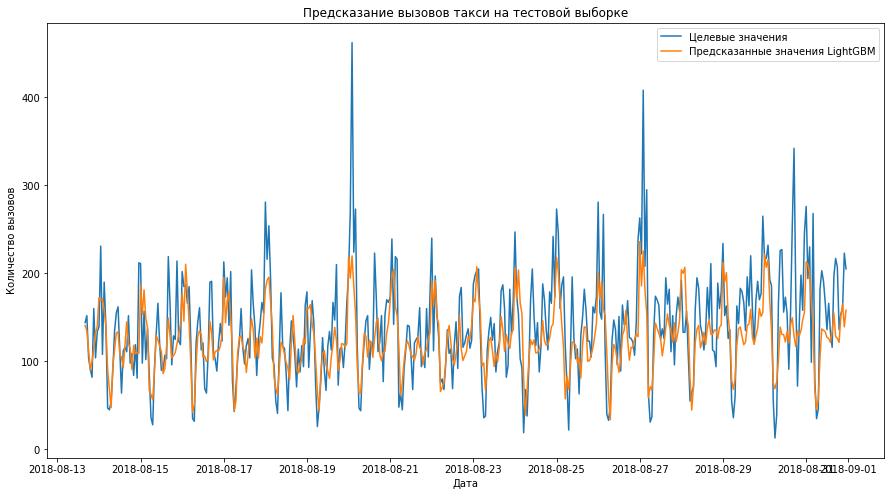

In [ ]:
target_list = target_test.tolist()
predicted_list = predicted_lgbm.tolist()
index_list = target_test.index.tolist()
plt.figure(figsize=(15, 8))
plt.plot(index_list, target_test, label = "Целевые значения")
plt.plot(index_list, predicted_list, label = "Предсказанные значения LightGBM")
plt.title("Предсказание вызовов такси на тестовой выборке")
plt.xlabel('Дата')
plt.ylabel("Количество вызовов");
plt.legend()
plt.show()

**Вывод**
Мы получиил предсказания наилучшей модели на тестовой выборке, визуализировали их и подсчитали значение RMSE.
На тестовой выборке показавшая наилучший результат среди прочих моделей LightGBM показала RMSE = 42.7.
В требуемую точность до 48  результат модели укладывается.

## Общий вывод ##

1. На этапе подготовки данных мы ознакомились с датасетом в 26496 строк, в котором содержались данные по числу заказов такси за полгода: с 1 марта 2018 по 31 августа 2018, за каждые 10 минут. Мы проверили данные на дубликаты и провели ресэмплирование данных на каждый час.

2. На этапе подготовки данных мы проанализировали временной ряд, увидели общую тенденцию к росту числа заказов такси, проанализировали сезоные составляющие, выявили сезонную суточную составляющую, убедились по тесту Дики-Фуллера в стационарности временного ряда, что показало нам, что  можно переходить к обучению моделей и прогнозированию.

3. На этапе обучения мы создали функции и обогатили датасет новыми признаками, выделили обучающие и целевой признаки, разбили датасет на обучающую и тестовую выборку в соотношении 90:10. Мы подобрали гиперпараметры и вычислили наилучшее знаечние RMSE при помощи кросс-валидации на следующих моделях:

- линейная регрессия
- дерево решений
- случайный лес
- CatBoost
- LightGBM

В результате получили наилучшее значение RMSE на модели LightGBM с количеством деревьев 90, количеством листьев 8, максимальной глубиной 8. Значение RMSE составило 26,456. Протестируем лучшую модель с подобранными параметрами на тестовой выборке.

4. На этапе тестирования мы получиил предсказания наилучшей модели на тестовой выборке, визуализировали их и подсчитали значение RMSE.

На тестовой выборке показавшая наилучший результат среди прочих моделей LightGBM показала RMSE = 42.7.
В требуемую точность до 48  результат модели укладывается.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48